In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv

import contractions
import nltk
from nltk.text import Text
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

import re 

In [2]:
df = pd.read_csv('washington_normal_2021.csv')

In [3]:
df

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/troycroz/status/1477065894...,2021-12-31 23:55:26+00:00,covid week mild kicking final lingering sympto...,covid week mild kicking final lingering sympto...,1477065894404763652,https://twitter.com/troycroz,0,0,1,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.064086, latitude=38....","Place(id='6417871953fa5e86', fullName='Silver ...",NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/Heerak4Congress/status/147...,2021-12-31 23:51:49+00:00,massachusetts representative ayannapressley an...,massachusetts representative ayannapressley an...,1477064984366616582,https://twitter.com/Heerak4Congress,0,0,0,0,...,NaN,NaN,"[User(username='AyannaPressley', id=31013444, ...","Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",NaN,NaN,SummaryCard(title='Representative Ayanna Press...,NaN,NaN
2,https://twitter.com/Heerak4Congress/status/147...,2021-12-31 23:48:51+00:00,breaking news new breakthrough covid case mass...,breaking news new breakthrough covid case mass...,1477064237306503172,https://twitter.com/Heerak4Congress,0,0,0,0,...,NaN,NaN,"[User(username='GOP', id=11134252, displayname...","Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",NaN,NaN,"SummaryCard(title='20,247 New Breakthrough Cas...",NaN,NaN
3,https://twitter.com/Heerak4Congress/status/147...,2021-12-31 23:44:49+00:00,wait next covid vaccine actually block omicron...,wait next covid vaccine actually block omicron...,1477063222654087171,https://twitter.com/Heerak4Congress,0,0,0,0,...,NaN,NaN,"[User(username='JoeBiden', id=939091, displayn...","Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",NaN,NaN,NaN,NaN,NaN
4,https://twitter.com/Heerak4Congress/status/147...,2021-12-31 23:41:37+00:00,president donald trump condemn expelling usmc ...,president donald trump condemn expelling usmc ...,1477062416471105536,https://twitter.com/Heerak4Congress,0,0,0,0,...,NaN,NaN,"[User(username='USMC', id=10126672, displaynam...","Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",NaN,NaN,SummaryCard(title='Marines kick out 206 troops...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19675,https://twitter.com/cefilby/status/13450877481...,2021-01-01 19:21:24+00:00,coronavirus death toll number lie many state d...,coronavirus death toll number lie many state d...,1345087748189798400,https://twitter.com/cefilby,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.19419, latitude=38.8...","Place(id='077e6b03695c28ee', fullName='Falls C...","['coronavirus', 'COVID19']",NaN,NaN,NaN,NaN
19676,https://twitter.com/LeavittDC/status/134504628...,2021-01-01 16:36:38+00:00,oh coronavirus get day public holiday cool,oh coronavirus get day public holiday cool,1345046284328165376,https://twitter.com/LeavittDC,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...",NaN,NaN,NaN,NaN,NaN
19677,https://twitter.com/Mr40watt/status/1345023287...,2021-01-01 15:05:15+00:00,reading smile survived fluke year time survive...,reading smile survived fluke year time survive...,1345023287320072195,https://twitter.com/Mr40watt,1,0,3,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.037081, latitude=38....","Place(id='2b8ddd2fad48eea2', fullName='Fort Wa...",['HappyNewYear2021'],NaN,NaN,NaN,NaN
19678,https://twitter.com/towens2921/status/13449593...,2021-01-01 10:51:19+00:00,espn thank god brawl canceled due coronavirus ...,espn thank god brawl canceled due coronavirus ...,1344959383550226433,https://twitter.com/towens2921,0,0,0,0,...,1.344750e+18,https://twitter.com/espn,"[User(username='espn', id=255752

In [4]:
df.isna().sum()

url                     0
date                    0
rawContent              4
renderedContent         4
id                      0
user                    0
replyCount              0
retweetCount            0
likeCount               0
quoteCount              0
conversationId          0
lang                    0
source                  0
sourceUrl               0
sourceLabel             0
links               15062
media               16803
retweetedTweet      19680
quotedTweet         16127
inReplyToTweetId    14502
inReplyToUser       14502
mentionedUsers      10414
coordinates             0
place                   0
hashtags            16466
cashtags            19673
card                17078
viewCount           19680
vibe                19680
dtype: int64

In [5]:
df['rawContent'].fillna('', inplace=True)
df['renderedContent'].fillna('', inplace=True)

In [6]:
## remove specific word HTTP
df['rawContent'] = df['rawContent'].str.replace('covid', '')
df['rawContent'] = df['rawContent'].str.replace('coronavirus', '')

df['renderedContent'] = df['renderedContent'].str.replace('covid', '')
df['renderedContent'] = df['renderedContent'].str.replace('coronavirus', '')

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

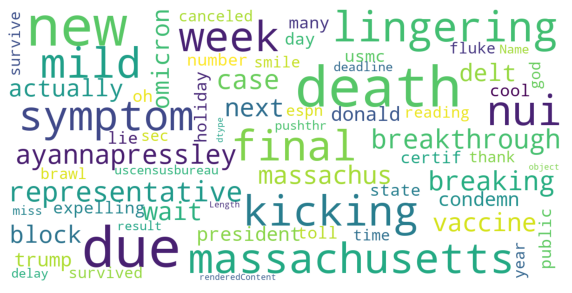

In [8]:
show_wordcloud(df["renderedContent"])

In [9]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [10]:
data = df['renderedContent'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['week', 'mild', 'kicking', 'final', 'lingering', 'symptom', 'nuisance', 'made', 'weird', 'family', 'holiday', 'lack', 'thereof']


## Building Bi-gram and Tri-gram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams

[['week',
  'mild',
  'kicking',
  'final',
  'lingering',
  'symptom',
  'nuisance',
  'made',
  'weird',
  'family',
  'holiday',
  'lack',
  'thereof'],
 ['massachusetts',
  'representative',
  'ayannapressley',
  'announced',
  'friday',
  'tested_positive',
  'breakthrough',
  'case',
  'breakthrough_infection',
  'killed',
  'colin_powell',
  'along',
  'thousand',
  'american',
  'new',
  'vaccine',
  'needed'],
 ['breaking_news',
  'new',
  'breakthrough',
  'case',
  'massachusetts',
  'death',
  'vaccinated',
  'people',
  'old',
  'vaccine',
  'ignore',
  'reality',
  'gop',
  'need',
  'new',
  'vaccine',
  'actually',
  'work',
  'protect',
  'variant'],
 ['wait',
  'next',
  'vaccine',
  'actually',
  'block',
  'omicron',
  'delta',
  'next',
  'variant',
  'infection',
  'yet',
  'vaccinated',
  'forever',
  'amp',
  'need',
  'effective',
  'vaccine',
  'every',
  'year',
  'joebiden',
  'must',
  'prioritize',
  'creation',
  'new',
  'vaccine',
  'every',
  'year',
 

In [14]:
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams

[['week',
  'mild',
  'kicking',
  'final',
  'lingering',
  'symptom',
  'nuisance',
  'made',
  'weird',
  'family',
  'holiday',
  'lack',
  'thereof'],
 ['massachusetts',
  'representative',
  'ayannapressley',
  'announced',
  'friday',
  'tested_positive',
  'breakthrough_case',
  'breakthrough_infection',
  'killed',
  'colin_powell',
  'along',
  'thousand',
  'american',
  'new',
  'vaccine',
  'needed'],
 ['breaking_news',
  'new',
  'breakthrough_case',
  'massachusetts',
  'death',
  'vaccinated',
  'people',
  'old',
  'vaccine',
  'ignore',
  'reality',
  'gop',
  'need',
  'new',
  'vaccine',
  'actually',
  'work',
  'protect',
  'variant'],
 ['wait',
  'next',
  'vaccine',
  'actually',
  'block',
  'omicron',
  'delta',
  'next',
  'variant',
  'infection',
  'yet',
  'vaccinated',
  'forever',
  'amp',
  'need',
  'effective',
  'vaccine',
  'every',
  'year',
  'joebiden',
  'must',
  'prioritize',
  'creation',
  'new',
  'vaccine',
  'every',
  'year',
  'nih'],
 

## Building rough LDA model 

In [15]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"get" + 0.014*"people" + 0.011*"vaccine" + 0.010*"shot" + '
  '0.010*"like" + 0.007*"know" + 0.007*"would" + 0.007*"going" + 0.006*"still" '
  '+ 0.006*"one"'),
 (1,
  '0.013*"trump" + 0.012*"amp" + 0.008*"biden" + 0.006*"vaccine" + '
  '0.006*"country" + 0.006*"state" + 0.006*"american" + 0.006*"pandemic" + '
  '0.005*"republican" + 0.005*"relief"'),
 (2,
  '0.034*"death" + 0.019*"new" + 0.017*"case" + 0.017*"vaccine" + '
  '0.017*"see_pinned_tweet" + 0.016*"amp" + 0.012*"unfortunately" + '
  '0.011*"million" + 0.011*"usa" + 0.010*"day"'),
 (3,
  '0.011*"people" + 0.010*"year" + 0.009*"amp" + 0.008*"get" + 0.007*"day" + '
  '0.007*"like" + 0.007*"time" + 0.006*"one" + 0.006*"back" + 0.005*"life"'),
 (4,
  '0.033*"vaccine" + 0.013*"get" + 0.010*"today" + 0.010*"dc" + '
  '0.008*"vaccination" + 0.008*"test" + 0.007*"first" + 0.006*"free" + '
  '0.006*"resident" + 0.005*"day"')]


In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.36698782020062914


## Tuning based on number of topics

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
       
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    # Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

coherence_scores = []
model_topics = []

for k in range(2, 20):
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=k) 
    model_topics.append(k)    
    coherence_scores.append(cv)    
    print("#Topics: " + str(k) + ", Score: " + str(coherence_scores[-1]))

print(datetime.datetime.now())

2023-03-12 03:20:27.329650
#Topics: 2, Score: 0.14254764310403784
#Topics: 3, Score: 0.3618995810803036
#Topics: 4, Score: 0.4303416229991953
#Topics: 5, Score: 0.40776123590581437
#Topics: 6, Score: 0.3789119402828675
#Topics: 7, Score: 0.3695800702410611
#Topics: 8, Score: 0.3453402656608016
#Topics: 9, Score: 0.3614628973100641
#Topics: 10, Score: 0.3619644655009647
#Topics: 11, Score: 0.4071233351445324
#Topics: 12, Score: 0.38100127416867385
#Topics: 13, Score: 0.4051941410544955
#Topics: 14, Score: 0.39943784784655406
#Topics: 15, Score: 0.36990667154094015
#Topics: 16, Score: 0.38902037321743527
#Topics: 17, Score: 0.37011346406823825
#Topics: 18, Score: 0.37885772939435486
#Topics: 19, Score: 0.39025861958792124
2023-03-12 03:38:38.063168


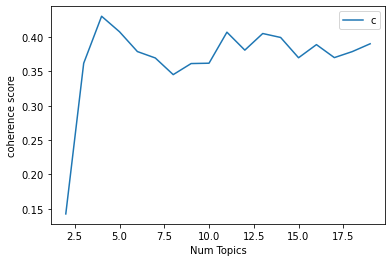

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence score"), loc='best')
plt.show()

In [22]:
end here

SyntaxError: invalid syntax (<ipython-input-22-9bcc9ab561c7>, line 1)

### Final Model

In [26]:
num_topics = 11

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

/Users/jon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
score = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
score.get_coherence()

/Users/jon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.39824463304516816

In [28]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./lda_model/washington_normal_2021_lda_vis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './lda_vis/washington_normal_2021_lda_vis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

/Users/jon/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.030433  0.172189       1        1  14.289414
6     -0.052897  0.100940       2        1  13.343881
0      0.108962  0.056241       3        1  10.708029
1      0.092545 -0.064683       4        1  10.124529
8      0.103273  0.009219       5        1   9.555398
10    -0.333347  0.117362       6        1   9.378109
2      0.156063 -0.020782       7        1   8.375579
9     -0.095358 -0.032047       8        1   7.381246
5      0.019950  0.059946       9        1   7.211794
3      0.113883 -0.077907      10        1   6.479845
7     -0.143507 -0.320478      11        1   3.152175, topic_info=                   Term         Freq        Total Category  logprob  loglift
28              vaccine  4147.000000  4147.000000  Default  30.0000  30.0000
31                death  1921.000000  1921.000000  Default  29.0000  29.0000
212                case  1081.000000  1081.000000  Default  28.0000  28.0000
42                  amp  2945.000000  2945.000000  Default  27.0000  27.0000
17773  see_pinned_tweet   951.000000   951.000000  Default  26.0000  26.0000
...                 ...          ...          ...      ...      ...      ...
2425           infected    59.098080   125.868477  Topic11  -4.9944   2.7010
351                 via    70.819119   265.958712  Topic11  -4.8134   2.1339
1779              worst    49.074992    97.018462  Topic11  -5.1802   2.7755
2227           outbreak    49.763261   110.806229  Topic11  -5.1663   2.6566
640            happened    46.618551    77.545183  Topic11  -5.2316   2.9482

[655 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1205      4  0.988418         act
3479      4  0.994535      action
4652      2  0.989513      actual
365       8  0.991893         add
3732      5  0.988729  additional
...     ...       ...         ...
57        7  0.078479        year
57        8  0.030520        year
57        9  0.326271        year
57       10  0.003633        year
2363      2  0.997220       young

[1284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 1, 2, 9, 11, 3, 10, 6, 4, 8])